In [1]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
import matplotlib.pyplot as plt
import databuilder

# Load all the data
db = databuilder.DataBuilder()

Loading ./Resources/COS2019.csv
Successfully loaded data for ./Resources/COS2019.csv
Loading ./Resources/COS2020.csv
Successfully loaded data for ./Resources/COS2020.csv
Loading ./Resources/COS2021.csv
Successfully loaded data for ./Resources/COS2021.csv
Loading ./Resources/COS2022.csv
Successfully loaded data for ./Resources/COS2022.csv
Loading ./Resources/COS2023.csv
Successfully loaded data for ./Resources/COS2023.csv

Successfully combined 5 files
Total records: 1,150,331
Loading ./Resources/full_moons.csv
Successfully loaded data for ./Resources/full_moons.csv

Successfully combined 1 files
Total records: 1,868
Loading ./Resources/merc_retro.csv
Successfully loaded data for ./Resources/merc_retro.csv

Successfully combined 1 files
Total records: 16
Loading ./Resources/Newmoondata.csv
Successfully loaded data for ./Resources/Newmoondata.csv

Successfully combined 1 files
Total records: 62


In [2]:
# Load the emergency dataset into Pandas dataframe and display first five rows
emergency_df = db.get_emergency_data()
display(emergency_df.head())

# Load the mercury dataset into Pandas dataframe and display first five rows
mercury_df =db.get_mercury_data()
display(mercury_df.head())

# Load the moon dataset into Pandas dataframe and display first five rows
moon_df = db.get_full_moon_data()
display(moon_df.head())



,INCIDENT,REPORTED,CLOSED,CATEGORY
0,19000004,2019-01-01 00:03:00,2019-01-01 01:22:00,ALS
1,19000006,2019-01-01 00:05:00,2019-01-01 00:29:00,ALS
2,19000008,2019-01-01 00:07:00,2019-01-01 00:20:00,ALS
3,19000011,2019-01-01 00:10:00,2019-01-01 00:23:00,BLS
4,19000013,2019-01-01 00:10:00,2019-01-01 00:36:00,ALS


,year,start_date,end_date
0,2019,2019-03-05,2019-03-28
1,2019,2019-07-07,2019-08-01
2,2019,2019-10-31,2019-11-20
3,2020,2020-02-16,2020-03-09
4,2020,2020-06-17,2020-07-11


,Day,Flag,DateTime
0,Monday,Full,2000-01-15 20:07:30
1,Wednesday,Full,2000-02-14 14:50:12
2,Friday,Full,2000-03-16 09:11:48
3,Sunday,Full,2000-04-15 02:02:06
4,Monday,Full,2000-05-14 16:36:36


# Part 1 - Does the number of emergency calls increase during a partial lunar eclipse? 

In [25]:
# Step 1: Extract Partial Lunar Eclipse Dates

import pandas as pd
import matplotlib.pyplot as plt

# Convert DateTime columns to datetime format
moon_df['DateTime'] = pd.to_datetime(moon_df['DateTime'])
emergency_df['REPORTED'] = pd.to_datetime(emergency_df['REPORTED'])

# Filter Partial Lunar Eclipses from 2019 to 2023
partial_eclipse_df = moon_df[(moon_df['Flag'] == 'Partial Eclipse') & 
                             (moon_df['DateTime'].dt.year >= 2019) & 
                             (moon_df['DateTime'].dt.year <= 2023)]

# Extract just the date
partial_eclipse_df = partial_eclipse_df.copy()  # Ensure it's a separate copy
partial_eclipse_df.loc[:, 'eclipse_date'] = partial_eclipse_df['DateTime'].dt.date
emergency_df['report_date'] = emergency_df['REPORTED'].dt.date

# Count emergency calls per day
emergency_counts = emergency_df.groupby('report_date').size()

# Count partial lunar eclipses per day
eclipse_counts = partial_eclipse_df.groupby('eclipse_date').size()

# Create a date range from 2019 to 2023 to align both datasets
date_range = pd.date_range(start='2019-01-01', end='2023-12-31')

# Reindex both datasets to ensure matching date indices
emergency_counts = emergency_counts.reindex(date_range, fill_value=0)
eclipse_counts = eclipse_counts.reindex(date_range, fill_value=0)

eclipse_counts.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Freq: D
Series name: None
Non-Null Count  Dtype
--------------  -----
1826 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


In [26]:
# Step 2: Process Emergency Call Data

# Convert emergency reported date to datetime format
emergency_df['REPORTED'] = pd.to_datetime(emergency_df['REPORTED'])

# Extract just the date for comparison
emergency_df['report_date'] = emergency_df['REPORTED'].dt.date

# Count emergency calls per day
emergency_counts = emergency_df.groupby('report_date').size()


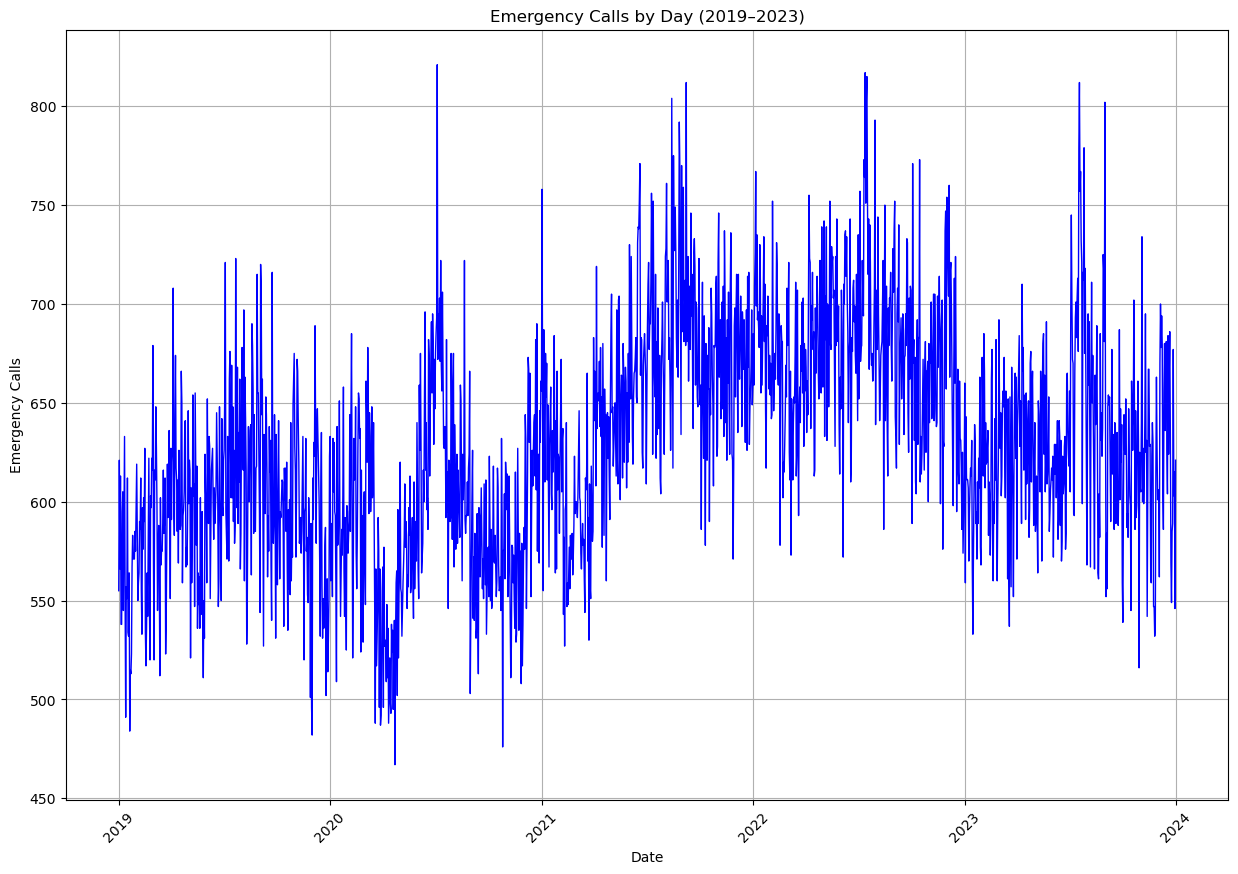

In [27]:
# Plot emergency calls as a line graph
plt.figure(figsize=(15, 10))
plt.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1)
plt.xlabel("Date")
plt.ylabel("Emergency Calls")
plt.title("Emergency Calls by Day (2019–2023)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


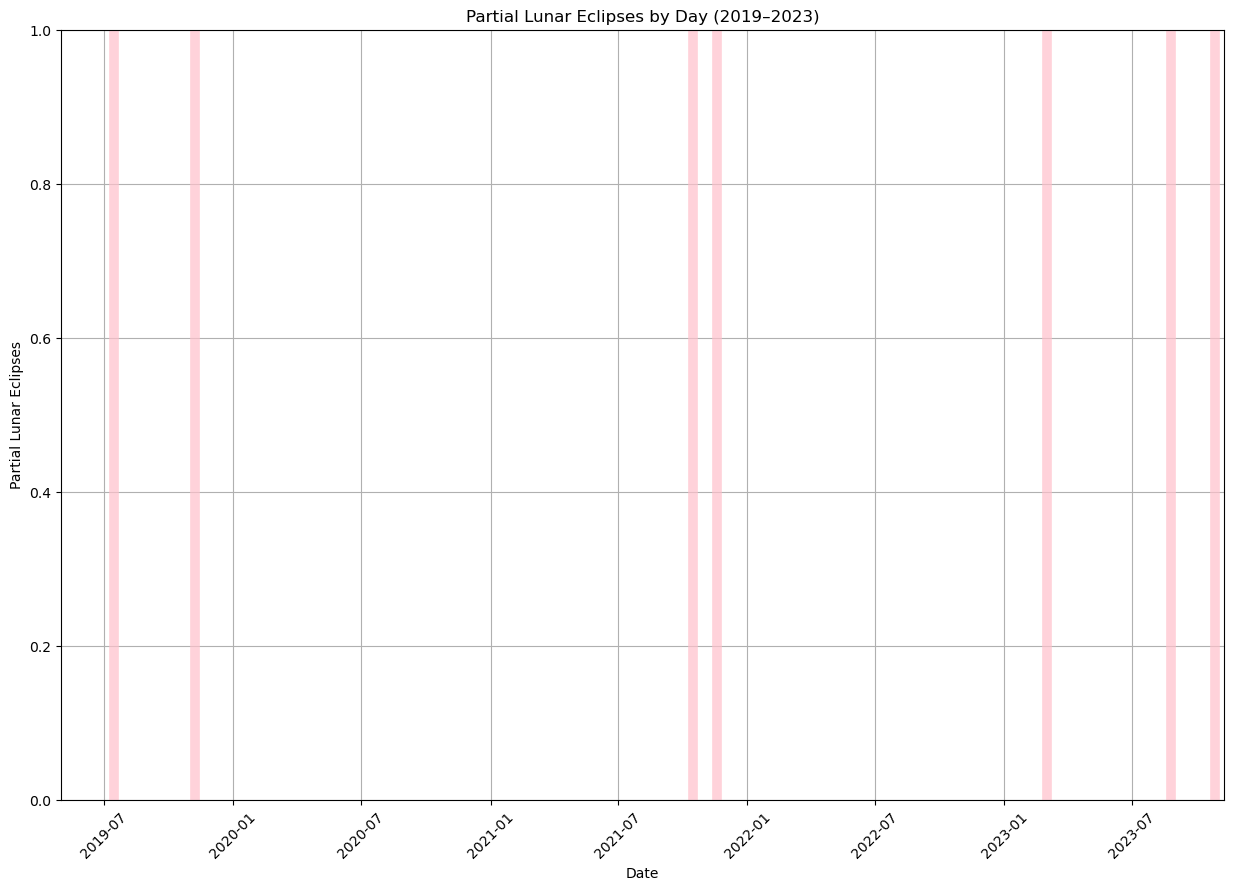

In [28]:
# Plot lunar eclipses as vertical lines
plt.figure(figsize=(15, 10))

# Loop through the unique eclipse dates and add a vertical line at each one
for eclipse_date in partial_eclipse_df['eclipse_date'].unique():
    plt.axvline(x=pd.to_datetime(eclipse_date), color='pink', linestyle='-', linewidth=7, alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Partial Lunar Eclipses")
plt.title("Partial Lunar Eclipses by Day (2019–2023)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



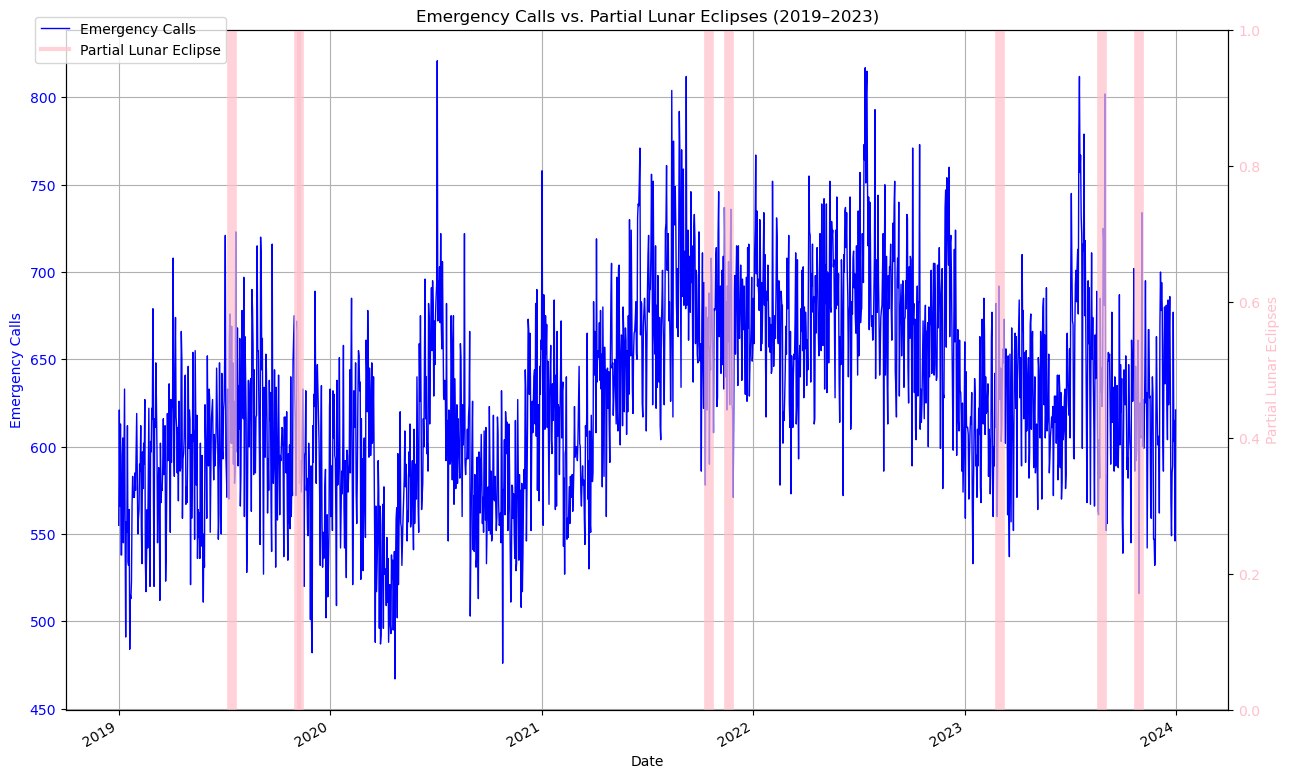

In [29]:
# Combine the graphs
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot emergency calls as a line graph
ax1.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1, label="Emergency Calls")
ax1.set_xlabel("Date")
ax1.set_ylabel("Emergency Calls", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for eclipses
ax2 = ax1.twinx()

# Plot vertical lines at eclipse dates using ax2
for eclipse_date in partial_eclipse_df['eclipse_date'].unique():
    ax2.axvline(x=pd.to_datetime(eclipse_date), color='pink', linestyle='-', linewidth=7, alpha=0.7)

# Add a single reference eclipse line for the legend (only once)
eclipse_legend = ax2.axvline(x=pd.to_datetime(partial_eclipse_df['eclipse_date'].iloc[0]), color='pink', linestyle='-', linewidth=3, alpha=0.7, label="Partial Lunar Eclipse")

ax2.set_ylabel("Partial Lunar Eclipses", color='pink')
ax2.tick_params(axis='y', labelcolor='pink')

# Titles and Legends
plt.title("Emergency Calls vs. Partial Lunar Eclipses (2019–2023)")
fig.autofmt_xdate()

# Add legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()




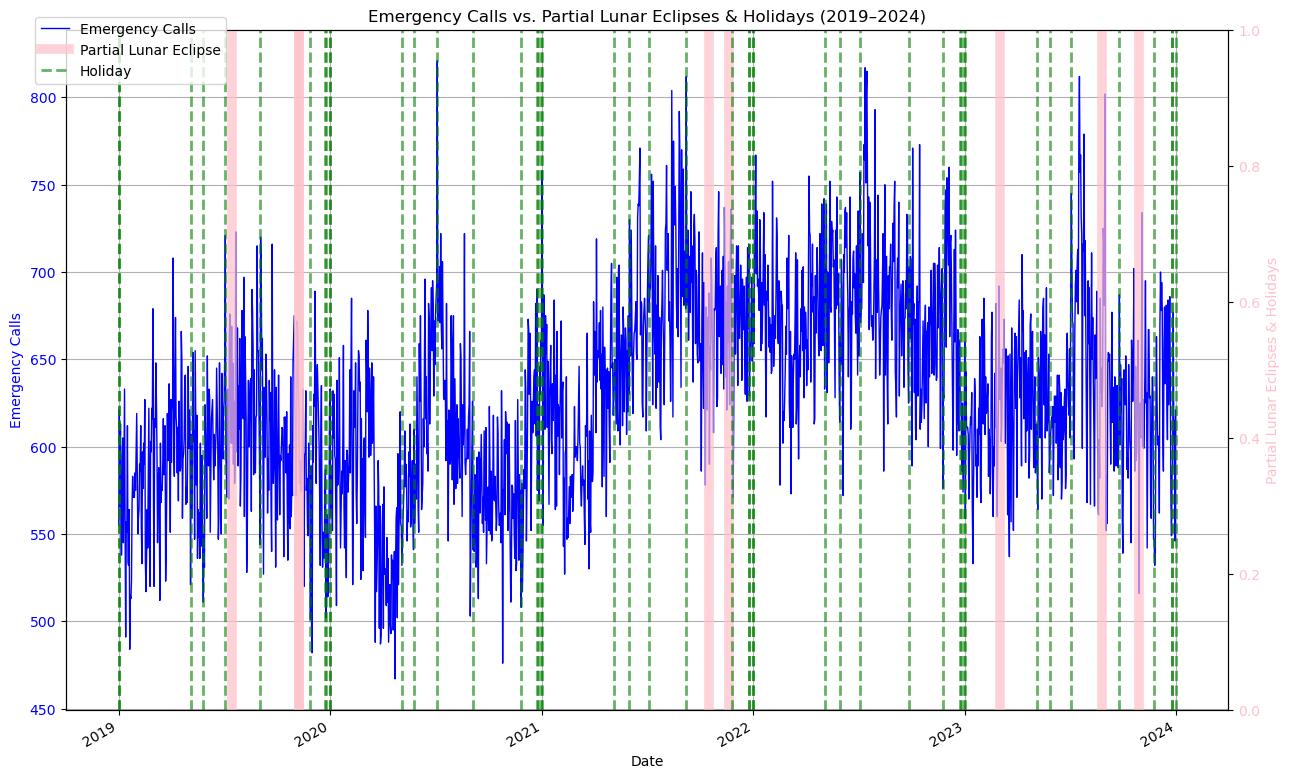

In [30]:
# Convert holiday dates to datetime format
holiday_dates = pd.to_datetime([
    "2019-01-01", "2019-05-05", "2019-05-27", "2019-07-04", "2019-09-02", "2019-11-28", "2019-12-24", "2019-12-25", "2019-12-31",
    "2020-01-01", "2020-05-05", "2020-05-25", "2020-07-04", "2020-09-04", "2020-11-26", "2020-12-24", "2020-12-25", "2020-12-31",
    "2021-01-01", "2021-05-05", "2021-05-31", "2021-07-04", "2021-09-06", "2021-11-25", "2021-12-24", "2021-12-25", "2021-12-31",
    "2022-01-01", "2022-05-05", "2022-05-30", "2022-07-04", "2022-09-26", "2022-11-24", "2022-12-24", "2022-12-25", "2022-12-31",
    "2023-01-01", "2023-05-05", "2023-05-29", "2023-07-04", "2023-09-25", "2023-11-23", "2023-12-24", "2023-12-25", "2023-12-31",
    ])

# Combine the graphs
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot emergency calls as a line graph
ax1.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1, label="Emergency Calls")
ax1.set_xlabel("Date")
ax1.set_ylabel("Emergency Calls", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for eclipses
ax2 = ax1.twinx()

# Plot vertical lines at eclipse dates using ax2
for eclipse_date in partial_eclipse_df['eclipse_date'].unique():
    ax2.axvline(x=pd.to_datetime(eclipse_date), color='pink', linestyle='-', linewidth=7, alpha=0.7)

# Add a single reference eclipse line for the legend (only once)
eclipse_legend = ax2.axvline(x=pd.to_datetime(partial_eclipse_df['eclipse_date'].iloc[0]), color='pink', linestyle='-', linewidth=7, alpha=0.7, label="Partial Lunar Eclipse")

# Plot holiday vertical lines using ax2
for holiday in holiday_dates:
    ax2.axvline(x=holiday, color='green', linestyle='--', linewidth=2, alpha=0.6)

# Add a single reference holiday line for the legend (only once)
holiday_legend = ax2.axvline(x=holiday_dates[0], color='green', linestyle='--', linewidth=2, alpha=0.6, label="Holiday")

ax2.set_ylabel("Partial Lunar Eclipses & Holidays", color='pink')
ax2.tick_params(axis='y', labelcolor='pink')

# Titles and Legends
plt.title("Emergency Calls vs. Partial Lunar Eclipses & Holidays (2019–2023)")
fig.autofmt_xdate()

# Add legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()


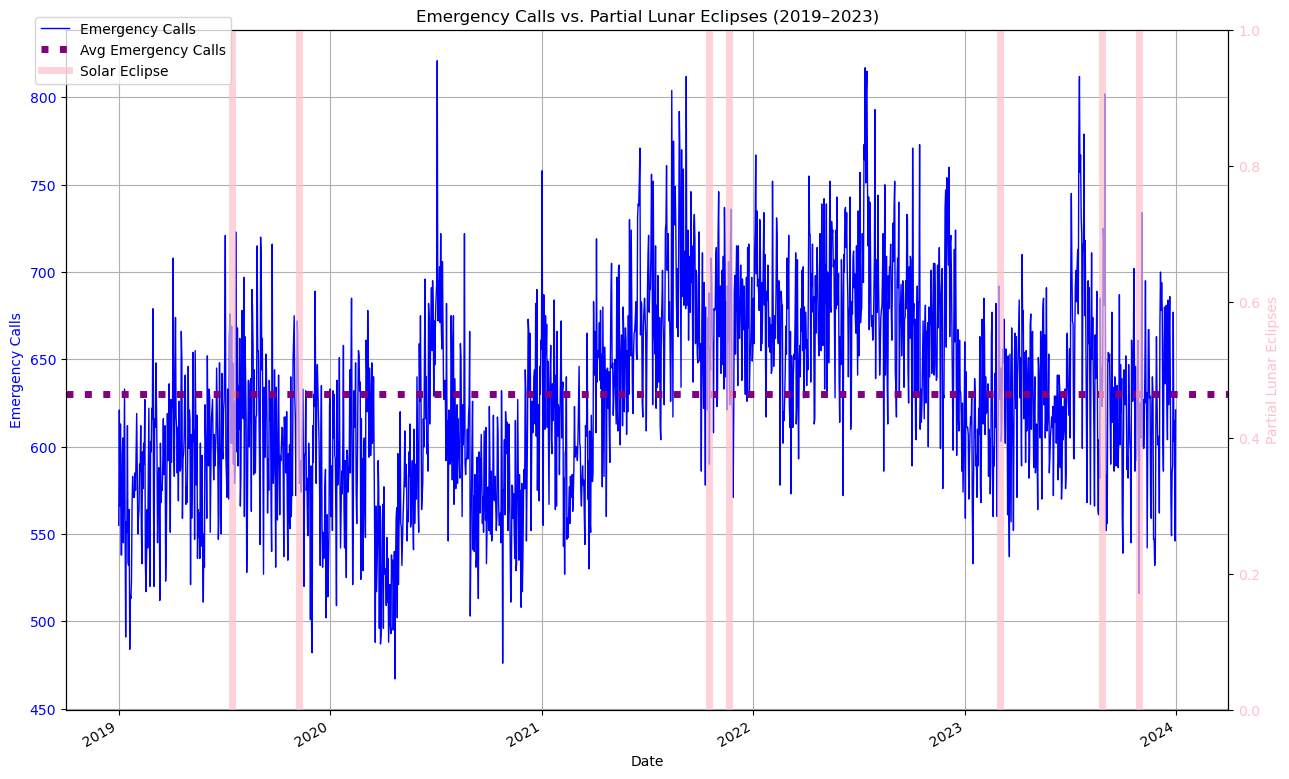

In [31]:
# Compute the average number of emergency calls
avg_calls = emergency_counts.mean()

# Combine the graphs
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot emergency calls as a line graph
ax1.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1, label="Emergency Calls")
ax1.set_xlabel("Date")
ax1.set_ylabel("Emergency Calls", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Add a horizontal dotted line at the average number of emergency calls
ax1.axhline(y=avg_calls, color='purple', linestyle='dotted', linewidth=5, label="Avg Emergency Calls")

# Create a secondary y-axis for eclipses
ax2 = ax1.twinx()

# Plot vertical lines at lunar eclipse dates
for eclipse_date in partial_eclipse_df['eclipse_date'].unique():
    ax2.axvline(x=pd.to_datetime(eclipse_date), color='pink', linestyle='-', linewidth=5, alpha=0.7, label="Solar Eclipse")

ax2.set_ylabel("Partial Lunar Eclipses", color='pink')
ax2.tick_params(axis='y', labelcolor='pink')

# Titles and Legends
plt.title("Emergency Calls vs. Partial Lunar Eclipses (2019–2023)")
fig.autofmt_xdate()

# Adjust legend to prevent duplicate labels
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels + labels2, handles + handles2))
fig.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()

In [32]:
# Merge the emergency calls and eclipse counts on the date
combined_df = pd.DataFrame({
    'emergency_calls': emergency_counts,
    'eclipse_counts': eclipse_counts
})

# Drop rows with no data (NaNs) from either emergency calls or eclipse counts
combined_df = combined_df.dropna()

# Calculate the Pearson correlation coefficient
correlation = combined_df['emergency_calls'].corr(combined_df['eclipse_counts'])

# Print the correlation
print(f"Correlation between Partial Lunar Eclipses and Emergency Calls: {correlation:.2f}")


Correlation between Partial Lunar Eclipses and Emergency Calls: 0.01


In [33]:
# What is the total number of emergency calls from 2019 - 2024?

total_emergency_calls = emergency_counts.sum()
print(f"Total emergency call from 2019 - 2024 : {total_emergency_calls}")

Total emergency call from 2019 - 2024 : 1150331


In [34]:
# Filter emergency calls for the specific lunar eclipse dates
eclipse_day_calls = emergency_counts[emergency_counts.index.isin(partial_eclipse_df['eclipse_date'])]

# Calculate the total number of calls on lunar eclipse days
total_eclipse_day_calls = eclipse_day_calls.sum()

# Display the result
print(f"Total emergency calls on partial lunar eclipse days: {total_eclipse_day_calls}")


Total emergency calls on partial lunar eclipse days: 4497


# Analysis:

## To answer the question 'Does the number of emergency calls increase during a partial lunar eclipse?' 
### Here are the steps I took:
#### I looked at the data for emergency calls from 2019 to 2024. 
#### I also looked at the data for lunar eclipses for the same date range.
#### I focused only on partial lunar eclipses in the time frame.
#### I provided a visual representation of both sets of data and overlaid them to see both sets of data in one single picture.


## Conclusion:
### - The total number of emergency calls between 2019 - 2024 was: 1,150,331
### - The total number of emergency calls during a partial lunar eclipse is: 4,497
### - The total number of emergency calls during a partial lunar eclipse is: <1%

### It appears that the data does not support the hypothesis of the level of emergency calls increasing during a partial lunar eclipse.



# Part 2 - Does the number of emergency calls increase during a partial solar eclipse?

In [40]:
# Step 1: Extract Partial Solar Eclipse Dates

import pandas as pd
import matplotlib.pyplot as plt

# Create a Solar Eclipse DF and convert to DateTime 
solar_eclipse_dates = ['2023-10-14']
solar_eclipse_df = pd.DataFrame({'eclipse_date': pd.to_datetime(solar_eclipse_dates)})

# Ensure the emergency report date is in datetime format
emergency_df['REPORTED'] = pd.to_datetime(emergency_df['REPORTED'])
emergency_df['report_date'] = emergency_df['REPORTED'].dt.date

# Count emergency calls per day
emergency_counts = emergency_df.groupby('report_date').size()

# Convert solar eclipse dates to match the index format
solar_eclipse_df['eclipse_date'] = solar_eclipse_df['eclipse_date'].dt.date

# Filter emergency calls for only the solar eclipse dates
eclipse_day_calls = emergency_counts[emergency_counts.index.isin(solar_eclipse_df['eclipse_date'])]

# Define the missing date_range variable**
date_range = pd.date_range(start='2019-01-01', end='2023-12-31')

# Reindex both datasets to ensure matching date indices**
emergency_counts = emergency_counts.reindex(date_range, fill_value=0)
eclipse_day_calls = eclipse_day_calls.reindex(date_range, fill_value=0)

# Display results
print(eclipse_day_calls)


2019-01-01    0
2019-01-02    0
2019-01-03    0
2019-01-04    0
2019-01-05    0
             ..
2023-12-27    0
2023-12-28    0
2023-12-29    0
2023-12-30    0
2023-12-31    0
Freq: D, Length: 1826, dtype: int64


In [41]:
# Step 2: Process Emergency Call Data

# Convert emergency reported date to datetime format
emergency_df['REPORTED'] = pd.to_datetime(emergency_df['REPORTED'])

# Extract just the date for comparison
emergency_df['report_date'] = emergency_df['REPORTED'].dt.date

# Count emergency calls per day
emergency_counts = emergency_df.groupby('report_date').size()
emergency_counts.head()

report_date
2019-01-01    555
2019-01-02    621
2019-01-03    566
2019-01-04    613
2019-01-05    538
dtype: int64

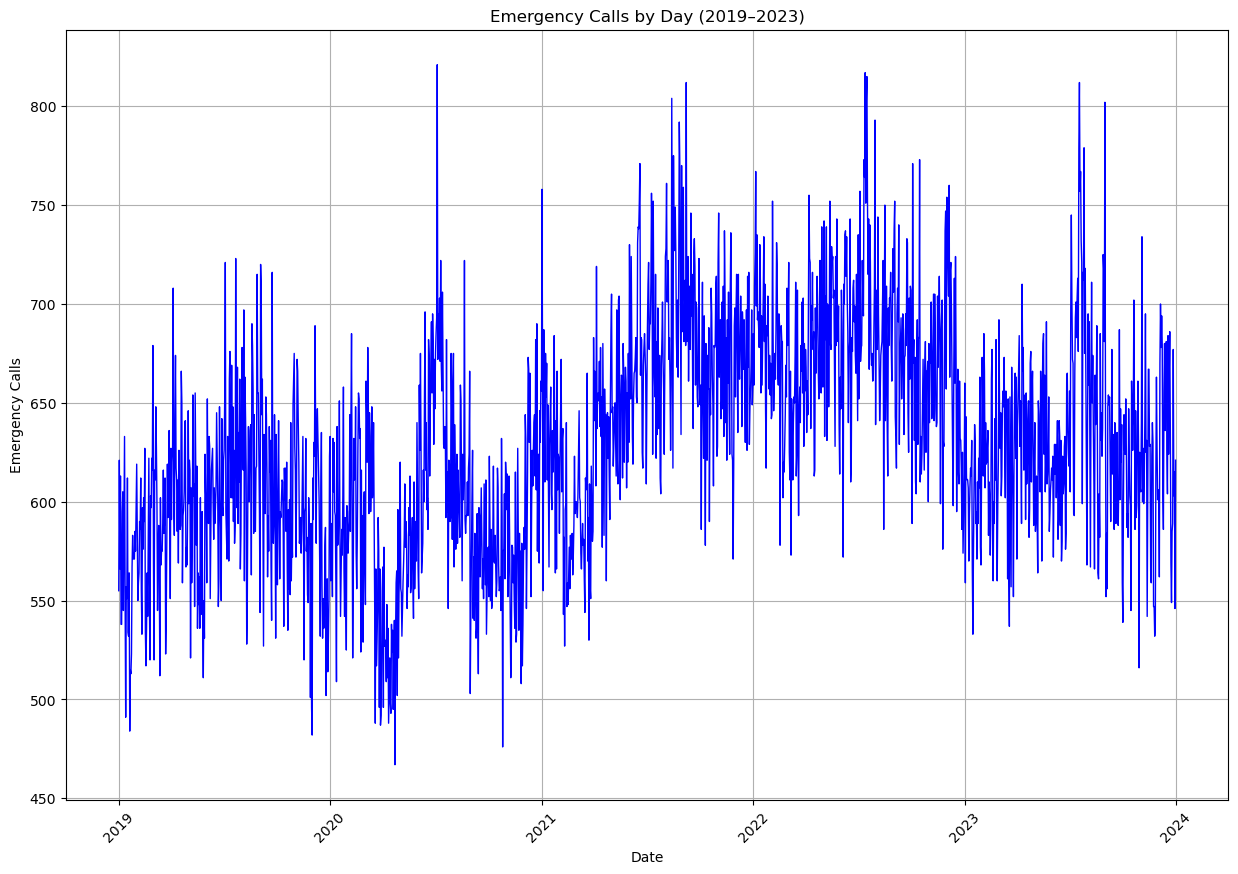

In [42]:
# Plot emergency calls as a line graph
plt.figure(figsize=(15, 10))
plt.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1)
plt.xlabel("Date")
plt.ylabel("Emergency Calls")
plt.title("Emergency Calls by Day (2019–2023)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

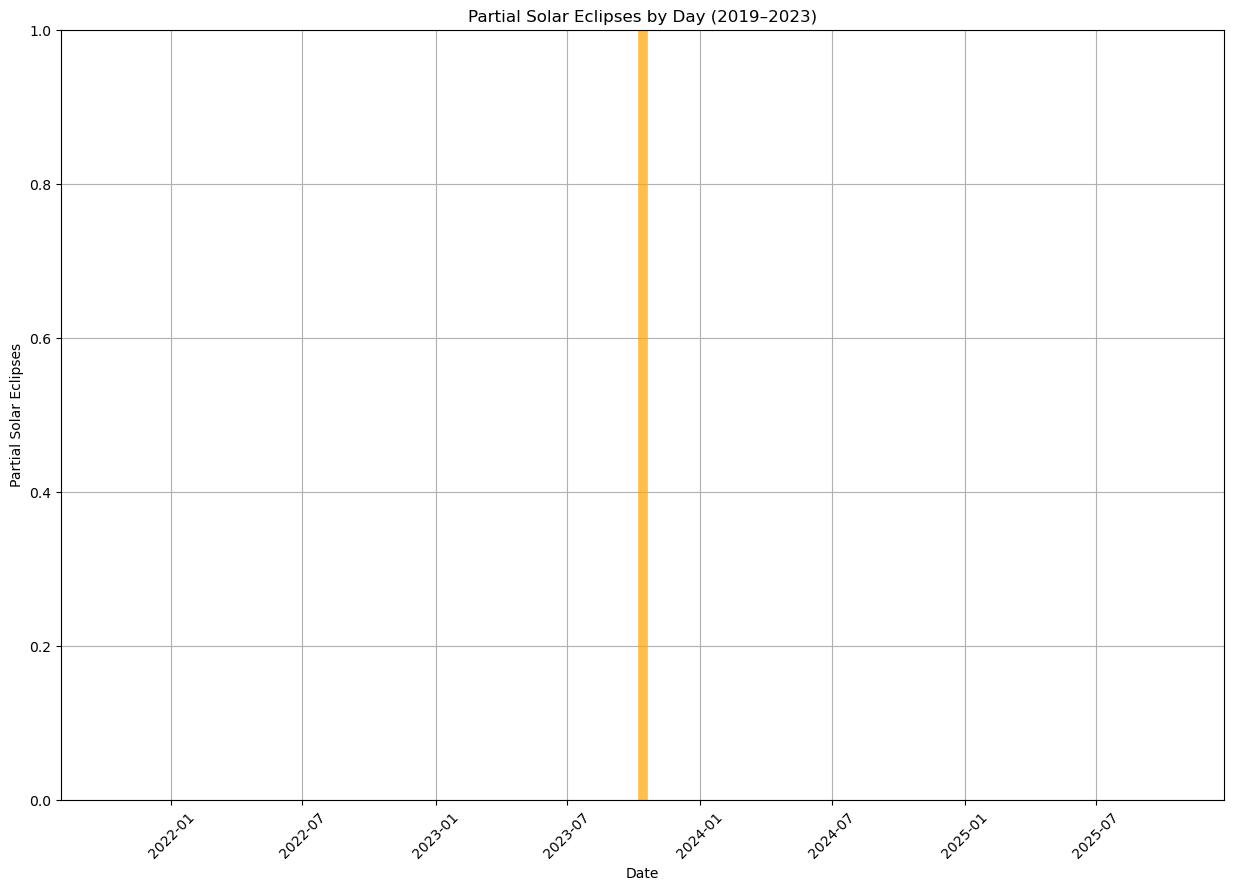

In [43]:
# Plot Solar Eclipses as vertical lines
plt.figure(figsize=(15, 10))

# Loop through the unique solar eclipse dates and add a vertical line at each one
for eclipse_date in solar_eclipse_df['eclipse_date'].unique():
    plt.axvline(x=pd.to_datetime(eclipse_date), color='orange', linestyle='-', linewidth=7, alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Partial Solar Eclipses")
plt.title("Partial Solar Eclipses by Day (2019–2023)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

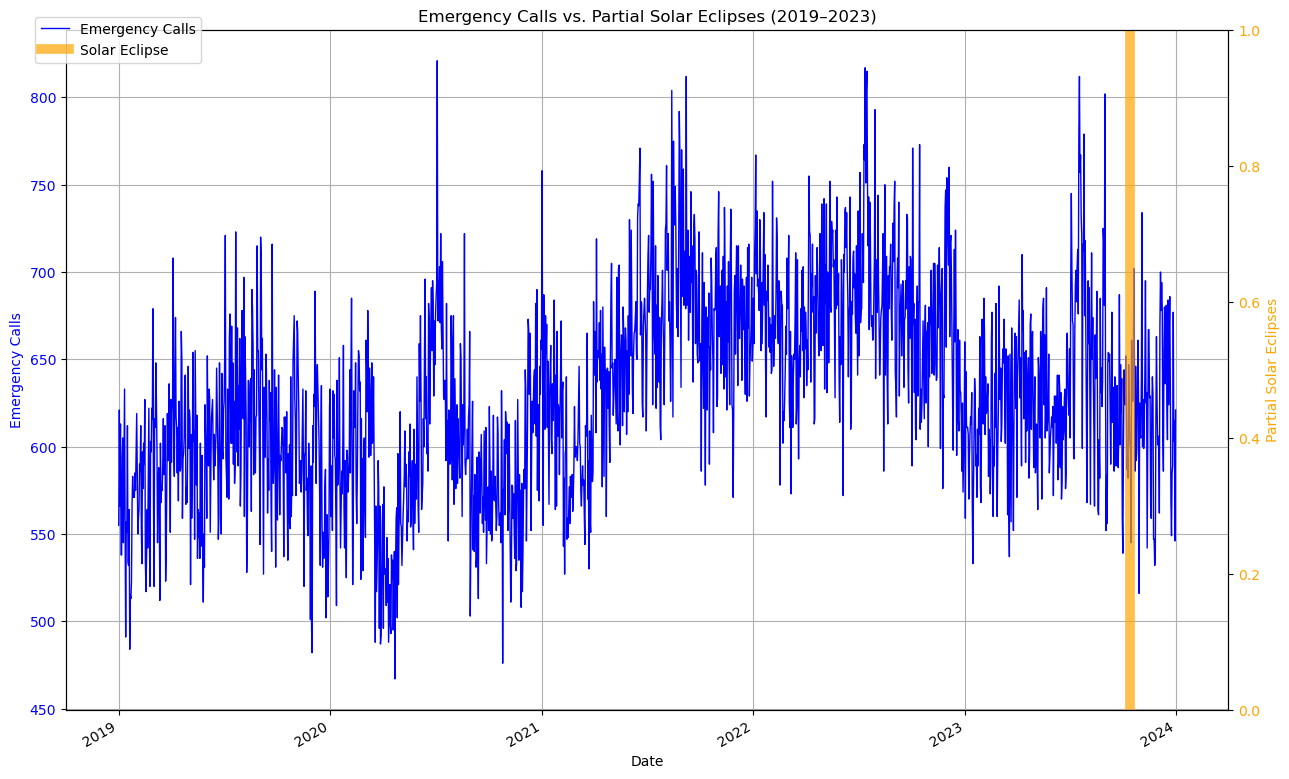

In [44]:
# Combine the graphs
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot emergency calls as a line graph
ax1.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1, label="Emergency Calls")
ax1.set_xlabel("Date")
ax1.set_ylabel("Emergency Calls", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for eclipses
ax2 = ax1.twinx()

# Plot vertical lines at solar eclipse dates
for eclipse_date in solar_eclipse_df['eclipse_date'].unique():
    ax2.axvline(x=pd.to_datetime(eclipse_date), color='orange', linestyle='-', linewidth=7, alpha=0.7, label="Solar Eclipse")

ax2.set_ylabel("Partial Solar Eclipses", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titles and Legends
plt.title("Emergency Calls vs. Partial Solar Eclipses (2019–2023)")
fig.autofmt_xdate()

# Adjust legend to prevent duplicate labels
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels + labels2, handles + handles2))
fig.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()


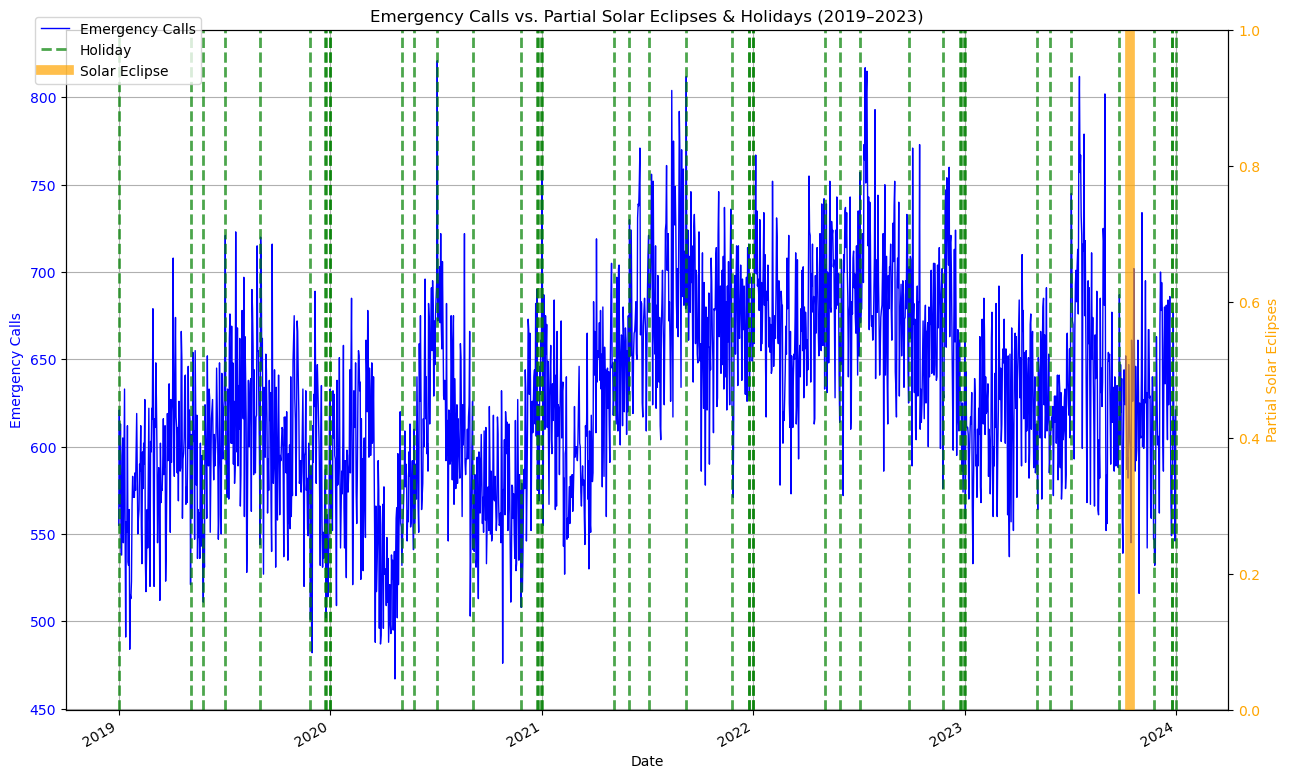

In [45]:
# Combine the graphs with holidays
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot emergency calls as a line graph
ax1.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1, label="Emergency Calls")
ax1.set_xlabel("Date")
ax1.set_ylabel("Emergency Calls", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for eclipses
ax2 = ax1.twinx()

# Plot vertical lines at solar eclipse dates
for eclipse_date in solar_eclipse_df['eclipse_date'].unique():
    ax2.axvline(x=pd.to_datetime(eclipse_date), color='orange', linestyle='-', linewidth=7, alpha=0.7, label="Solar Eclipse")

ax2.set_ylabel("Partial Solar Eclipses", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Plot vertical lines for holidays
for holiday in holiday_dates:
    ax1.axvline(x=holiday, color='green', linestyle='--', linewidth=2, alpha=0.7, label="Holiday")

# Titles and Legends
plt.title("Emergency Calls vs. Partial Solar Eclipses & Holidays (2019–2023)")
fig.autofmt_xdate()

# Adjust legend to prevent duplicate labels
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels + labels2, handles + handles2))
fig.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()


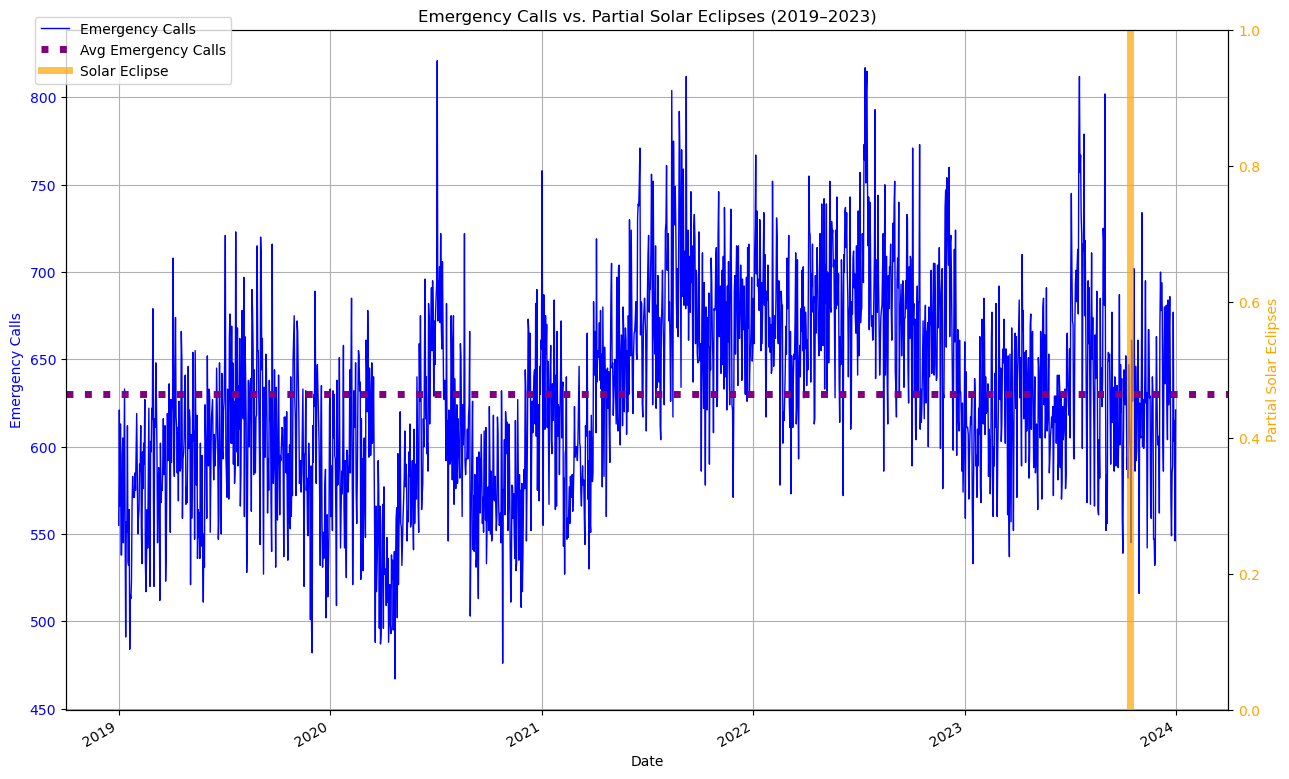

In [46]:
# Compute the average number of emergency calls
avg_calls = emergency_counts.mean()

# Combine the graphs
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot emergency calls as a line graph
ax1.plot(emergency_counts.index, emergency_counts.values, color='blue', linestyle='-', linewidth=1, label="Emergency Calls")
ax1.set_xlabel("Date")
ax1.set_ylabel("Emergency Calls", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Add a horizontal dotted line at the average number of emergency calls
ax1.axhline(y=avg_calls, color='purple', linestyle='dotted', linewidth=5, label="Avg Emergency Calls")

# Create a secondary y-axis for eclipses
ax2 = ax1.twinx()

# Plot vertical lines at solar eclipse dates
for eclipse_date in solar_eclipse_df['eclipse_date'].unique():
    ax2.axvline(x=pd.to_datetime(eclipse_date), color='orange', linestyle='-', linewidth=5, alpha=0.7, label="Solar Eclipse")

ax2.set_ylabel("Partial Solar Eclipses", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titles and Legends
plt.title("Emergency Calls vs. Partial Solar Eclipses (2019–2023)")
fig.autofmt_xdate()

# Adjust legend to prevent duplicate labels
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels + labels2, handles + handles2))
fig.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()


In [47]:
# Step 1: Create a variable for solar eclipse counts (1 for solar eclipse, 0 for no eclipse)
# This step creates a series where each date has 1 if it's a solar eclipse, and 0 if not
eclipse_counts = emergency_counts.index.isin(solar_eclipse_df['eclipse_date']).astype(int)

# Step 2: Combine the emergency call data and eclipse data into a new dataframe
combined_df = pd.DataFrame({
    'emergency_calls': emergency_counts,
    'eclipse_counts': eclipse_counts
})

# Step 3: Drop any rows with missing data (if any)
combined_df = combined_df.dropna()

# Step 4: Calculate the Pearson correlation coefficient
correlation = combined_df['emergency_calls'].corr(combined_df['eclipse_counts'])

# Step 5: Print the correlation
print(f"Correlation between partial solar eclipses and emergency calls: {correlation:.2f}")


Correlation between partial solar eclipses and emergency calls: -0.01


In [48]:
# What is the total number of emergency calls from 2019 - 2024?

total_emergency_calls = emergency_counts.sum()
print(f"Total emergency call from 2019 - 2024 : {total_emergency_calls}")

Total emergency call from 2019 - 2024 : 1150331


In [49]:
# Step 1: Filter emergency calls for the specific solar eclipse dates
solar_eclipse_day_calls = emergency_counts[emergency_counts.index.isin(solar_eclipse_df['eclipse_date'])]

# Step 2: Calculate the total number of calls on solar eclipse days
total_solar_eclipse_calls = solar_eclipse_day_calls.sum()

# Step 3: Display the result
print(f"Total emergency calls on partial solar eclipse days: {total_solar_eclipse_calls}")



Total emergency calls on partial solar eclipse days: 598


# Analysis:

## To answer the question 'Does the number of emergency calls increase during a partial solar eclipse?' 
### Here are the steps I took:
#### I looked at the data for emergency calls from 2019 to 2024. 
#### I also looked at the data for solar eclipses for the same date range.
#### I focused only on partial solar eclipses in the time frame.
#### I provided a visual representation of both sets of data and overlaid them to see both sets of data in one single picture.


## Conclusion:
### - The total number of emergency calls between 2019 - 2024 was: 1,150,331
### - The total number of emergency calls during a partial solar eclipse is: 598
### - The total number of emergency calls during a partial solar eclipse is: <1%

### It appears that the data does not support the hypothesis of the level of emergency calls increasing during a partial solar eclipse.